Iteraciones: 2203


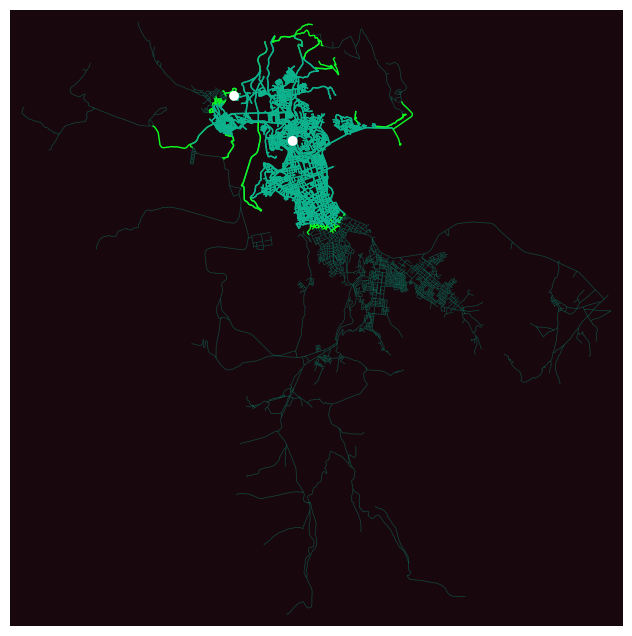

Distancia: 4.217042000000001 km
Velocidad promedio: 44.888888888888886 km/h
Tiempo total de viaje: 5.636640297029705 min


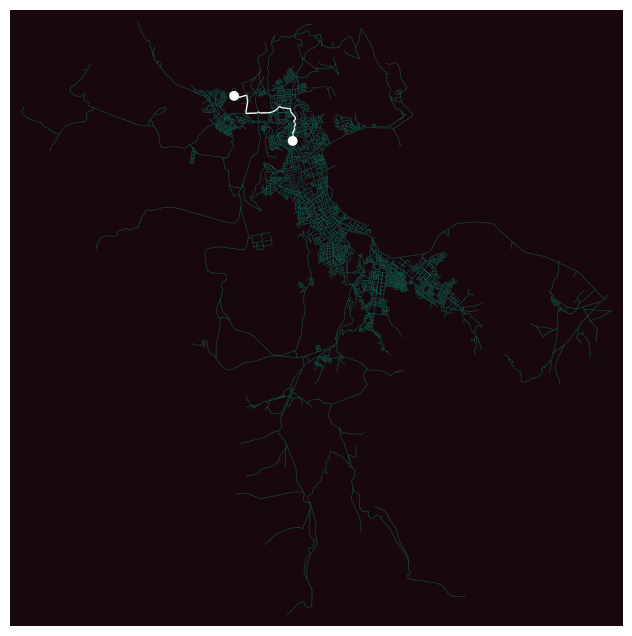

(4.217042000000001, 44.888888888888886, 5.636640297029705)

In [6]:
import osmnx as ox
import random
import heapq

place_name = "Puno, Puno, Perú"
G = ox.graph_from_place(place_name, network_type="drive")

for edge in G.edges:
    maxspeed = 40
    if "maxspeed" in G.edges[edge]:
        maxspeed = G.edges[edge]["maxspeed"]
        if type(maxspeed) == list:
            speeds = [ int(speed) for speed in maxspeed ]
            maxspeed = min(speeds)
        elif type(maxspeed) == str:
            maxspeed = int(maxspeed)
    G.edges[edge]["maxspeed"] = maxspeed
    # Añadiendo el atributo "weight" (tiempo = distancia / velocidad)
    G.edges[edge]["weight"] = G.edges[edge]["length"] / maxspeed


def estilo_arista_no_visitada(edge):        
    G.edges[edge]["color"] = "#0db48e"
    G.edges[edge]["alpha"] = 0.2
    G.edges[edge]["linewidth"] = 0.5

def estilo_arista_visitada(edge):
    G.edges[edge]["color"] = "#0db48e"
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

def estilo_arista_activa(edge):
    G.edges[edge]["color"] = '#0dff1c'
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

def estilo_arista_ruta(edge):
    G.edges[edge]["color"] = "white"
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

def grafico():
    ox.plot_graph(
        G,
        node_size =  [ G.nodes[node]["size"] for node in G.nodes ],
        edge_color = [ G.edges[edge]["color"] for edge in G.edges ],
        edge_alpha = [ G.edges[edge]["alpha"] for edge in G.edges ],
        edge_linewidth = [ G.edges[edge]["linewidth"] for edge in G.edges ],
        node_color = "white",
        bgcolor = "#18080e"
    )

def dijkstra(orig, dest, plot=False):
    for node in G.nodes:
        G.nodes[node]["visited"] = False
        G.nodes[node]["distance"] = float("inf")
        G.nodes[node]["previous"] = None
        G.nodes[node]["size"] = 0
    for edge in G.edges:
        estilo_arista_no_visitada(edge)
    G.nodes[orig]["distance"] = 0
    G.nodes[orig]["size"] = 50
    G.nodes[dest]["size"] = 50
    pq = [(0, orig)]
    iteraciones = 0
    while pq:
        _, node = heapq.heappop(pq)
        if node == dest:
            if plot:
                print("Iteraciones:", iteraciones)
                grafico()
            return iteraciones
        if G.nodes[node]["visited"]: continue
        G.nodes[node]["visited"] = True
        for edge in G.out_edges(node):
            estilo_arista_visitada((edge[0], edge[1], 0))
            vecino = edge[1]
            weight = G.edges[(edge[0], edge[1], 0)]["weight"]
            if G.nodes[vecino]["distance"] > G.nodes[node]["distance"] + weight:
                G.nodes[vecino]["distance"] = G.nodes[node]["distance"] + weight
                G.nodes[vecino]["previous"] = node
                heapq.heappush(pq, (G.nodes[vecino]["distance"], vecino))
                for edge2 in G.out_edges(vecino):
                    estilo_arista_activa((edge2[0], edge2[1], 0))
        iteraciones += 1
    return iteraciones

def reconstruir_ruta(orig, dest, plot=False, algorithm=None):
    for edge in G.edges:
        estilo_arista_no_visitada(edge)
    dist = 0
    speeds = []
    curr = dest
    while curr != orig:
        prev = G.nodes[curr]["previous"]
        dist += G.edges[(prev, curr, 0)]["length"]
        speeds.append(G.edges[(prev, curr, 0)]["maxspeed"])
        estilo_arista_ruta((prev, curr, 0))
        if algorithm:
            G.edges[(prev, curr, 0)][f"{algorithm}_uses"] = G.edges[(prev, curr, 0)].get(f"{algorithm}_uses", 0) + 1
        curr = prev
    dist /= 1000  # Convertir a kilómetros
    avg_speed = sum(speeds) / len(speeds)  # Velocidad promedio en km/h
    tiempo_viaje = (dist / avg_speed) * 60  # Tiempo en minutos

    if plot:
        print(f"Distancia: {dist} km")
        print(f"Velocidad promedio: {avg_speed} km/h")
        print(f"Tiempo total de viaje: {tiempo_viaje} min")
        grafico()

    return dist, avg_speed, tiempo_viaje

start = random.choice(list(G.nodes))
end = random.choice(list(G.nodes))

dijkstra(start, end, plot=True)
reconstruir_ruta(start, end, plot=True)